In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import random
from sklearn.model_selection import KFold
import matplotlib.pyplot  as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

In [2]:
data=pd.read_csv('Final.csv',index_col=0)
data.head()

,WIND_SPEED,RAIN,SNOW,SNOW_DEPTH,TAVG,FOG,HEAVY_FOG,THUNDER,HAIL,GLAZE,...,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,7.83,0.0,0.0,0.0,72,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,7.83,0.0,0.0,0.0,72,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,7.83,0.0,0.0,0.0,72,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,7.83,0.0,0.0,0.0,72,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,7.83,0.0,0.0,0.0,72,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [3]:
random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(data.drop('Y',axis=1), data['Y'], test_size=0.25)

In [4]:
def hyperparameter_tuning(X_train,y_train,cs):
    cs_l1=dict((n,[]) for n in cs)
    cs_l2=dict((n,[]) for n in cs)
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(X_train):
        cv_train_x,cv_validate_x= X_train.iloc[train_index],X_train.iloc[test_index]
        cv_train_y,cv_validate_y= y_train.iloc[train_index],y_train.iloc[test_index]
        for n in cs:
            neigh_l1 = KNeighborsClassifier(n_neighbors=n,weights='distance',metric='l1').fit(cv_train_x,cv_train_y)
            cs_l1[n].append(roc_auc_score(cv_validate_y, neigh_l1.predict_proba(cv_validate_x)[:,1]))
            neigh_l2=KNeighborsClassifier(n_neighbors=n,weights='distance',metric='l2').fit(cv_train_x,cv_train_y)
            cs_l2[n].append(roc_auc_score(cv_validate_y, neigh_l2.predict_proba(cv_validate_x)[:,1]))
    return (cs_l1,cs_l2)

In [5]:
cs=[1,2,3,5,7,10,25,50]
acc_l1,acc_l2=hyperparameter_tuning(X_train,y_train,cs)


In [6]:
mean_acc_l1=[]
stderr_acc_l1=[]
mean_acc_l2=[]
stderr_acc_l2=[]
mean_l1=0
mean_l2=0
for c in cs:
    x_l1=np.array(acc_l1[c])
    m_l1=np.mean(x_l1)
    v_l1=np.var(x_l1)
    mean_acc_l1.append(m_l1)
    stderr_acc_l1.append(np.sqrt(v_l1/len(x_l1)))
    
    x_l2=np.array(acc_l2[c])
    m_l2=np.mean(x_l2)
    v_l2=np.var(x_l2)
    mean_acc_l2.append(m_l2)
    stderr_acc_l2.append(np.sqrt(v_l2/len(x_l2)))
    
    
mean_acc_l1=np.array(mean_acc_l1)
stderr_acc_l1=np.array(stderr_acc_l1)
mean_acc_l2=np.array(mean_acc_l2)
stderr_acc_l2=np.array(stderr_acc_l2)

Text(0.5, 0, 'cs')

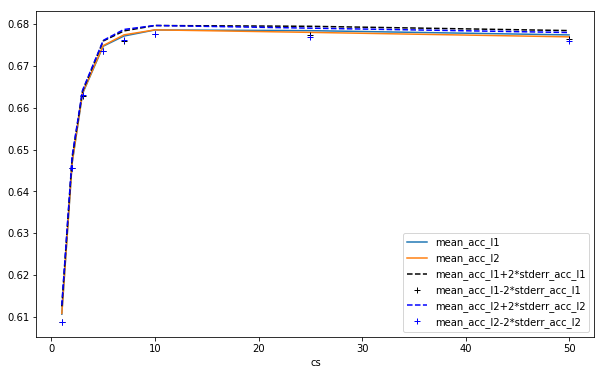

In [7]:
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
plt.plot(cs, mean_acc_l1, label='mean_acc_l1')
plt.plot(cs, mean_acc_l2, label='mean_acc_l2')
plt.plot(cs, mean_acc_l1+2*stderr_acc_l1, 'k--', label='mean_acc_l1+2*stderr_acc_l1')
plt.plot(cs, mean_acc_l1-2*stderr_acc_l1, 'k+',label='mean_acc_l1-2*stderr_acc_l1')
plt.plot(cs, mean_acc_l2+2*stderr_acc_l2, 'b--', label='mean_acc_l2+2*stderr_acc_l2')
plt.plot(cs, mean_acc_l2-2*stderr_acc_l2, 'b+',label='mean_acc_l2-2*stderr_acc_l2')
plt.legend(loc = 4)
ax.set_xlabel('cs')

In [8]:
mean_acc_l1+2*stderr_acc_l1

array([0.6125112 , 0.64812393, 0.66395902, 0.67598512, 0.67840264,
       0.67968982, 0.67950577, 0.67847998])

In [9]:
from sklearn import metrics
neigh=KNeighborsClassifier(n_neighbors=5,weights='distance',metric='l2').fit(X_train,y_train)
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test, neigh.predict_proba(X_test)[:,1])
lr_auc=roc_auc_score(y_test, neigh.predict_proba(X_test)[:,1])

Text(0, 0.5, 'TP rate')

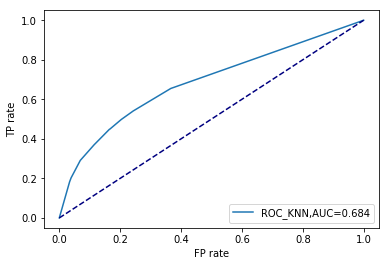

In [10]:
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
plt.plot( fpr_lr,tpr_lr, label='ROC_KNN,AUC={}'.format(round(lr_auc,3)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend(loc = 4)
ax.set_xlabel('FP rate')
ax.set_ylabel('TP rate')

In [13]:
cm=confusion_matrix(y_test,neigh.predict(X_test))
prec=cm[0][0]/(cm[0][1]+cm[0][0])
recall=cm[0][0]/(cm[1][0]+cm[0][0])
f=2*prec*recall/(prec+recall)
print ('FP Rate:{}'.format(cm[0][1]/(cm[0][1]+cm[0][0])))
print ('Precision:{}'.format(prec))
print ('Recall:{}'.format(recall))
print ('FN rate:{}'.format(cm[1][0]/(cm[1][0]+cm[0][0])))
print ('Accuracy:{}'.format(neigh.score(X_test,y_test)))
print ('F-Score:{}'.format(f))

FP Rate:0.06892386892386893
Precision:0.9310761310761311
Recall:0.8471342743134058
FN rate:0.15286572568659418
Accuracy:0.8084471194634311
F-Score:0.8871239311603601


In [16]:
target=['0','1']
print (classification_report(y_test,neigh.predict(X_test), target_names=target))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89    101010
           1       0.50      0.29      0.37     23932

   micro avg       0.81      0.81      0.81    124942
   macro avg       0.67      0.61      0.63    124942
weighted avg       0.78      0.81      0.79    124942

